In [1]:
import healpy as hp
import pandas as pd
import numpy as np
import astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
%matplotlib inline

In [18]:
planck_z = pd.read_csv('../healpy/planck_z.csv')

In [19]:
def ra_dec_distance(ra, dec, ra1, dec1):
    import numpy as np
    from astropy import units as u
    from astropy.coordinates import SkyCoord
    c1 = SkyCoord(ra=ra, dec=dec, unit='deg')
    c2 = SkyCoord(ra=ra1, dec=dec1, unit='deg')
    sep = c1.separation(c2)
    return sep.degree

In [20]:
def n_src_in_radius(cat, center, radius):
    #center : [ra dec]
    dists = ra_dec_distance(center[0], center[1], cat['RAdeg'], cat['DEdeg'])
    return np.count_nonzero(dists < radius.degree) 

In [21]:
def n_pix2ra_dec(npix, nside):
    theta, phi = hp.pix2ang(nside=nside, ipix=[npix], nest=True, lonlat=True)
    sc = SkyCoord(l=theta*u.degree, b=phi*u.degree, frame='galactic')
    return sc.icrs.ra.degree, sc.icrs.dec.degree

In [26]:
def gen_centers(cat, n, radius=astropy.coordinates.Angle('1d'), nside=2**11, func=None):
    npix = hp.nside2npix(nside)
    a = np.arange(npix)
    if not (func is None):
        a = a[func(a, nside=nside)]
    ans = []
    while len(ans) < n:
        num = np.random.choice(a)
        if n_src_in_radius(cat, n_pix2ra_dec(num, nside), radius) > 0:
            ans.append(num)
    return np.array(ans)

In [30]:
a = gen_centers(planck_z, 20)
print(a)

[45367884 42440932 12452791 47777884 35696134 15964125 39068722 21059237
 43843129  8870174 47513732 46228438 41782592  3389373  4187208 25085748
 24601423  2787388 29361481 35157112]


In [28]:
def show_pix(a, nside=2**11):
    m = np.zeros((hp.nside2npix(nside)), dtype=np.int32)
    for npix in a:
        vec = hp.pix2vec(nside=nside, ipix=npix, nest=True)
        ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=np.radians(1), nest=True)
        m[ipix_disc] = 1
    hp.mollview(m, title="Mollview image NEST", nest=True)

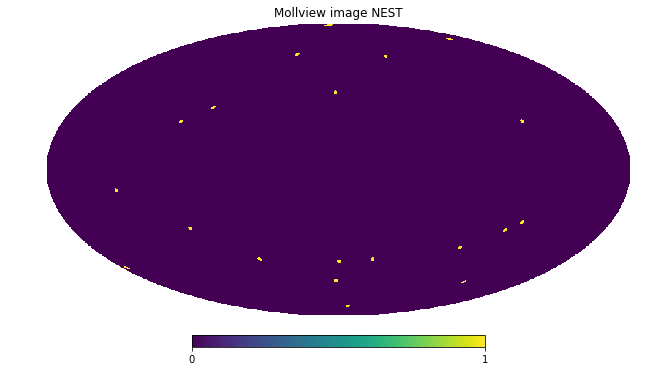

In [31]:
show_pix(a)

In [2]:
def in_nth_pix(n, nside, nbig=6, nbigside=2):
    vec = hp.pix2vec(nest=True, nside=nside, ipix=n)
    return hp.vec2pix(nside=nbigside, x=vec[0], y=vec[1], z=vec[2], nest=True) == nbig

In [32]:
b = gen_centers(planck_z, 20, func=in_nth_pix)
print(b)

[6733794 6723465 7259934 6408368 6786904 6864470 6862811 7037222 6954525
 7014696 7012400 6963856 7220229 6568223 7083251 7262410 6785299 6800231
 6407154 6731494]


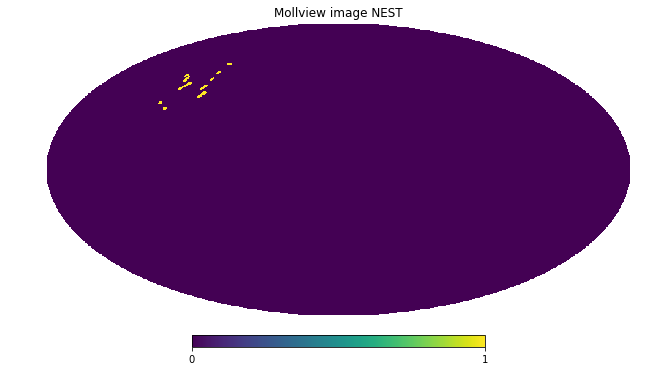

In [33]:
show_pix(b)

In [34]:
patches6 = gen_centers(planck_z, 50, func=in_nth_pix)

In [40]:
def pix2radec(npix, nside):
    df = pd.DataFrame()
    theta, phi = hp.pix2ang(nest=True, ipix=npix, nside=nside, lonlat=True)
    sc = SkyCoord(l=theta * u.degree, b = phi * u.degree, frame='galactic')
    df['RAdeg'] = sc.icrs.ra.degree
    df['DEdeg'] = sc.icrs.dec.degree
    return df    

In [41]:
df = pix2radec(patches6, 2 ** 11)

In [45]:
df.head()

,RAdeg,DEdeg
0,217.863483,66.544666
1,201.670396,59.717376
2,252.315480,78.270121
3,199.211097,69.733384
4,197.642895,64.562792


In [55]:
df.index.name = 'id'

In [56]:
df.head()

,RAdeg,DEdeg
id,,
0,217.863483,66.544666
1,201.670396,59.717376
2,252.315480,78.270121
3,199.211097,69.733384
4,197.642895,64.562792


In [53]:
print(df.index.name)

index


In [57]:
df.to_csv('./patches_centers6.csv')

In [2]:
df = pd.read_csv('./patches_centers6.csv')

In [3]:
df.head()

,id,RAdeg,DEdeg
0,0,217.863483,66.544666
1,1,201.670396,59.717376
2,2,252.315480,78.270121
3,3,199.211097,69.733384
4,4,197.642895,64.562792


In [4]:
df.shape

(50, 3)

In [12]:
df.drop(['id'], axis='columns', inplace=True)
df.head()

,RAdeg,DEdeg
0,217.863483,66.544666
1,201.670396,59.717376
2,252.315480,78.270121
3,199.211097,69.733384
4,197.642895,64.562792


In [13]:
df.index.name = 'id'
df.head()

,RAdeg,DEdeg
id,,
0,217.863483,66.544666
1,201.670396,59.717376
2,252.315480,78.270121
3,199.211097,69.733384
4,197.642895,64.562792


In [14]:
for i in range(5):
    start = df.shape[0] // 5
    start *= i
    end = start + df.shape[0] // 5
    df[start: end].to_csv('./patch_c%i.csv' % i)